TODO before testing
1. Adjust base line value when idle in load data


In [194]:
import os
import re
import numpy as np
import pandas as pd
from scipy.fft import fft
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [195]:
#load data
DATA_DIR = "data/"
baseline_adc = 2370 #baseline value when idle

#Helper to extract metadata from filename
def extract_metadata(filename):
    name = filename.lower()
    material = "coin" if "coin" in name else "eraser"
    d = int(re.search(r'd(\d+)', name).group(1))
    h = int(re.search(r'h(\d+)', name).group(1))
    label = f"{material}_D{d}_H{h}"
    return material, d, h, label

#Helper to safely parse ADC values
def parse_adc_values(raw_text):
    cleaned = re.sub(r'[^0-9,]', '', raw_text)  # keep numbers AND commas
    nums = [int(n) for n in cleaned.split(',') if n.strip().isdigit()]
    return np.array(nums)

#load all files and extract data
all_features = []

for fname in os.listdir(DATA_DIR):
    if not fname.endswith('.txt'):
        continue

    filepath = os.path.join(DATA_DIR, fname)
    with open(filepath,'r') as f:
        content = f.read()

    #extract metadata
    material, dist, height, label = extract_metadata(fname)

    #fine drop blocks
    drop_sections = re.findall(r'(Drop number: \d+\n)?([0-9,\s]+)', content)


    for drop_raw in drop_sections:
        adc = parse_adc_values(drop_raw[1])
        if len(adc) < 10:
            print(f"⚠️ Skipped short drop in file: {fname}")
            continue #skip short drops

        #nornmalize signal
        signal = adc - baseline_adc

        #Extract features
        fft_vals = np.abs(fft(signal))[:len(signal)//2]
        
        features = {
            'material' : material,
            'distance_cm' : dist,
            'height_cm' : height,
            'label' : label,
            'peak_amplitude' : np.max(np.abs(signal)),
            'energy' : np.sum(signal ** 2),
            'duration' : np.sum(np.abs(signal) > 0.1 * np.max(np.abs(signal))),
            'zero_crossings' : np.count_nonzero(np.diff(np.sign(signal))),
            'dominant_freq_bin' : np.argmax(fft_vals),
            'spectral_centroid' : np.sum(np.arange(len(fft_vals))*fft_vals)/np.sum(fft_vals)
        }

        all_features.append(features)

#convert to DataFrame
df = pd.DataFrame(all_features)  # ✅ correct — all drops from all files

df.head()
print(df['label'].value_counts())


⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coinD10H30.txt
⚠️ Skipped short drop in file: coi

Classification Report:

                precision    recall  f1-score   support

  coin_D10_H10       0.97      1.00      0.98        28
  coin_D10_H30       0.96      0.93      0.95        28
  coin_D30_H10       0.61      0.61      0.61        28
  coin_D30_H30       0.66      0.68      0.67        31
eraser_D10_H10       0.87      0.69      0.77        29
eraser_D10_H30       0.74      0.83      0.78        30
eraser_D30_H10       0.77      0.79      0.78        29
eraser_D30_H30       0.77      0.77      0.77        30

      accuracy                           0.79       233
     macro avg       0.79      0.79      0.79       233
  weighted avg       0.79      0.79      0.79       233



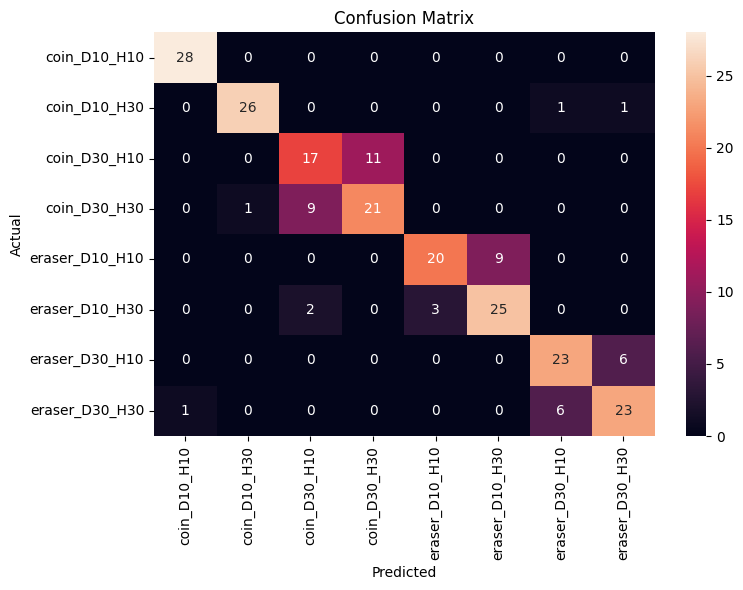

In [196]:
# Step 3: Encode labels and split data
# Encode string labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Features and target
features = ['peak_amplitude', 'energy', 'duration', 'zero_crossings',
            'dominant_freq_bin', 'spectral_centroid']
X = df[features]
y = df['label_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

NameError: name 'features_to_plot' is not defined

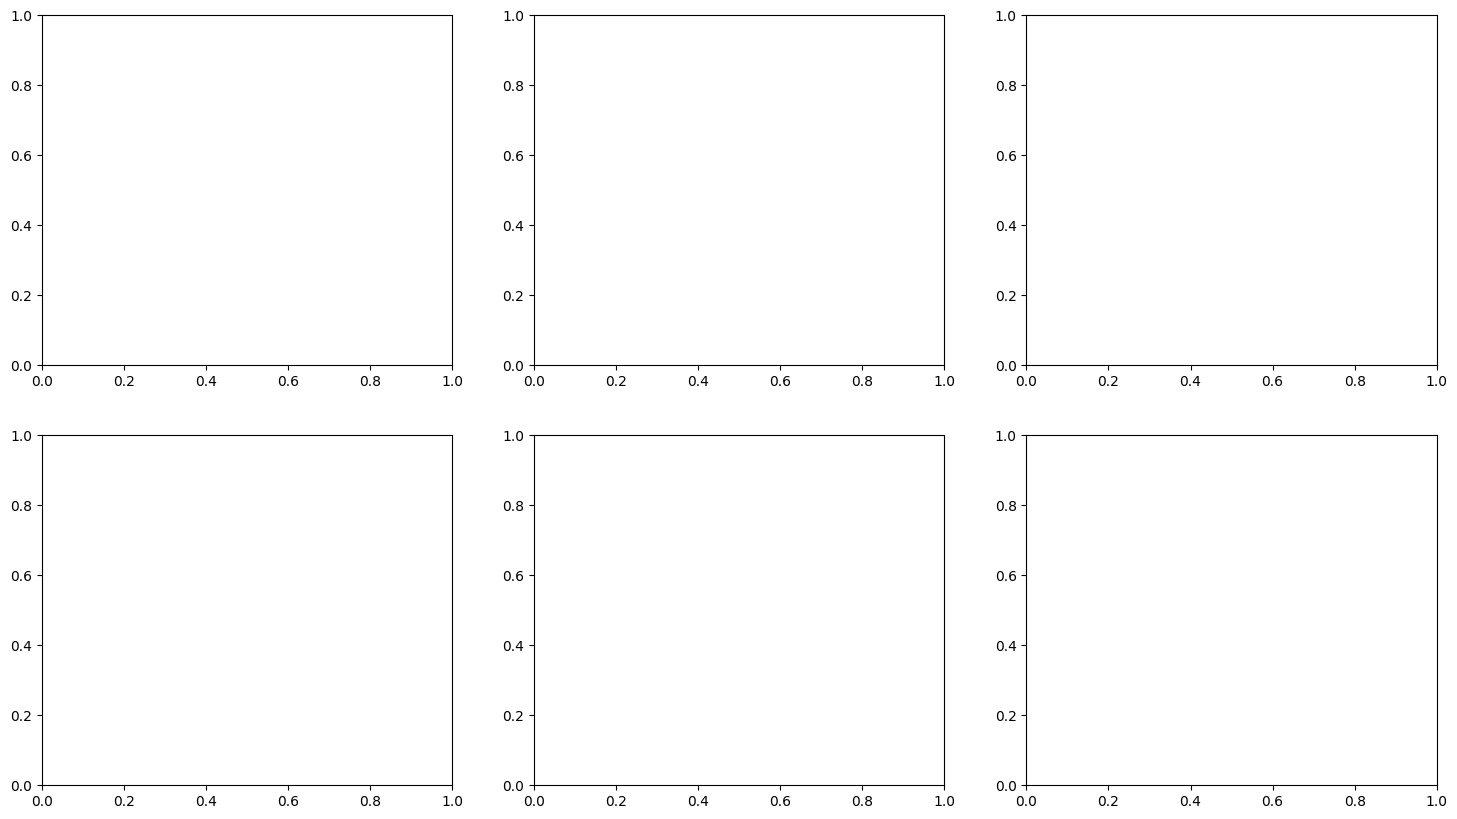

In [197]:
# Set up 2x3 grid for subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for ax, feature in zip(axs.flat, features_to_plot):
    sns.boxplot(data=df, x='label', y=feature, ax=ax)
    ax.set_title(f'{feature} by Class Label')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

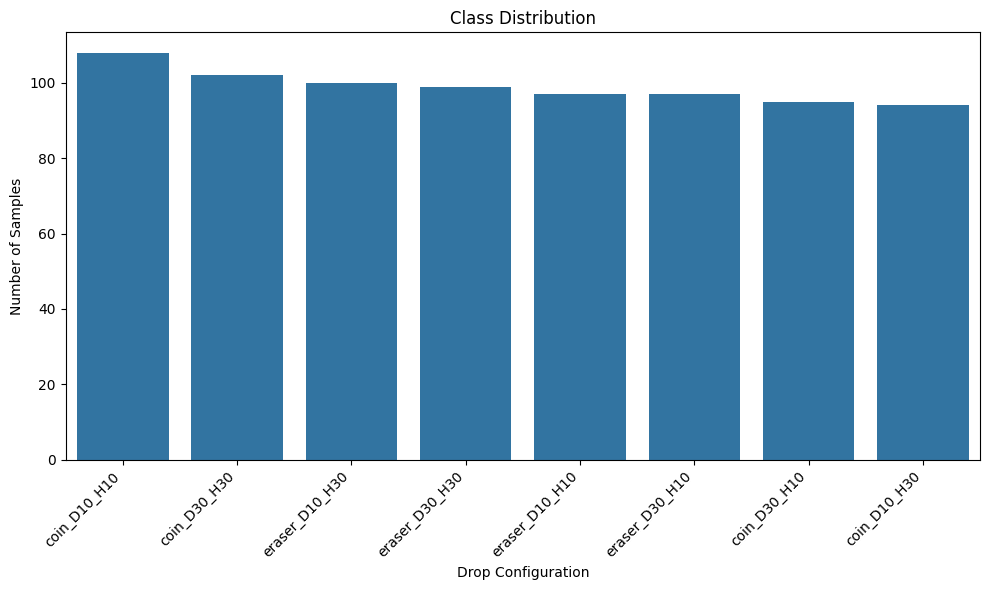

In [ ]:
# Visualize class imbalance
# Plot class counts
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Drop Configuration')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Predict function
def predict_drop_condition(adc_values, model, label_encoder, baseline=2370):
    """
    Predict the drop condition from raw ADC input using a trained model.
    
    Parameters:
        adc_values (list or np.array): Raw ADC readings from a single drop.
        model (sklearn model): Trained classifier (e.g., RandomForestClassifier).
        label_encoder (LabelEncoder): Fitted label encoder used during training.
        baseline (int): The resting/stable ADC value.

    Returns:
        str: Predicted class label (e.g., 'coin_D10_H10')
    """
    adc = np.array(adc_values)
    signal = adc - baseline
    fft_vals = np.abs(fft(signal))[:len(signal)//2]

    features = {
        'peak_amplitude': np.max(np.abs(signal)),
        'energy': np.sum(signal ** 2),
        'duration': np.sum(np.abs(signal) > 0.1 * np.max(np.abs(signal))),
        'zero_crossings': np.count_nonzero(np.diff(np.sign(signal))),
        'dominant_freq_bin': np.argmax(fft_vals),
        'spectral_centroid': np.sum(np.arange(len(fft_vals)) * fft_vals) / np.sum(fft_vals)
    }

    # Ensure input order matches training feature order
    X_input_df = pd.DataFrame([features])[[
    'peak_amplitude', 'energy', 'duration',
    'zero_crossings', 'dominant_freq_bin', 'spectral_centroid'
    ]]

    # Predict using DataFrame
    prediction_index = model.predict(X_input_df)[0]
    predicted_label = label_encoder.inverse_transform([prediction_index])[0]
    
    return predicted_label

In [ ]:
# Time to predict
# Replace this with your own ADC input (single drop)
adc_test_sample = [3334, 2047, 2538, 1803, 2739, 2252, 2067, 3052, 2252, 2503, 2243, 2432, 2188, 2530, 2147, 2470, 2366, 2250, 2364, 2560, 2314, 2322, 2390, 2392, 2390, 2424, 2400, 2410, 2426, 2408, 2440, 2294, 2417, 2352, 2384, 2376, 2354, 2354, 2380, 2350, 2342, 2392, 2318, 2372, 2352, 2366, 2358, 2346, 2370, 2336, 2391, 2344, 2362, 2378, 2352, 2382, 2342, 2382, 2390, 2352, 2387, 2347, 2355, 2376, 2362, 2381, 2358, 2366, 2382, 2362, 2378, 2368, 2372, 2367, 2370, 2379, 2367, 2380, 2376, 2362, 2370, 2370, 2376, 2376, 2371, 2362, 2376, 2368, 2363, 2372, 2370, 2366, 2368, 2371, 2374, 2367, 2373, 2378, 2372, 2376, 2376, 2374, 2378, 2371, 2379, 2374, 2370, 2370, 2376, 2370, 2367, 2373, 2370, 2366, 2371, 2370, 2368, 2370, 2370, 2374, 2370, 2372, 2374, 2370, 2372, 2369, 2371, 2374, 2370, 2373, 2370, 2370, 2370, 2371, 2370, 2371, 2370, 2362, 2371, 2366, 2363, 2372, 2370, 2378, 2371, 2374, 2368, 2370, 2362, 2348, 2368, 2370, 2370, 2370, 2370, 2373, 2371, 2371, 2374, 2370, 2374, 2368, 2374, 2371, 2374, 2374, 2368, 2372, 2370, 2370, 2370, 2371, 2370, 2370, 2370, 2374, 2374, 2372, 2374, 2371, 2374, 2374, 2374, 2370, 2371, 2370, 2357, 2371, 2370, 2354, 2374, 2370, 2370, 2371, 2376, 2372, 2370, 2366, 2370, 2374, 2370, 2370, 2366, 2372, 2364, 2308, 2427, 2371, 2370, 2370, 2370, 2371, 2370, 2372, 2370, 2371, 2372, 2372, 2373, 2370, 2374, 2372, 2373, 2371, 2370, 2370, 2370, 2374, 2371, 2370, 2372, 2370, 2370, 2370, 2370, 2372, 2373, 2372, 2372, 2374, 2374, 2374, 2371, 2376, 2373, 2371, 2372, 2372, 2371, 2370, 2370, 2370, 2369, 2372, 2371, 2370, 2372, 2372, 2372, 2372, 2371, 2372, 2371, 2372, 2370, 2371, 2371, 2369, 2370, 2370, 2370, 2370, 2370, 2372, 2370, 2371, 2370, 2374, 2374, 2371, 2374, 2368, 2374, 2374, 2364, 2372, 2374, 2367, 2371, 2371, 2372, 2370, 2370, 2370, 2371, 2372, 2374, 2372, 2372, 2371, 2374, 2374, 2370, 2374, 2372, 2371, 2371, 2370, 2371, 2370, 2370, 2370, 2370, 2371, 2371, 2370, 2370, 2371, 2372, 2384, 2373, 2372, 2372, 2372, 2371, 2371, 2370, 2371, 2370, 2371, 2370, 2371, 2371, 2370, 2370, 2374, 2372, 2372, 2374, 2372, 2374, 2372, 2371, 2371, 2370, 2372, 2374, 2370, 2370, 2371, 2370, 2370, 2370, 2372, 2376, 2380, 2372, 2394, 2367, 2372, 2372, 2374, 2372, 2370, 2372, 2372, 2371, 4022, 943, 2804, 2689, 1654, 1660, 2220, 2582, 2646, 2067, 2276, 2418, 2362, 2390, 2676, 2278, 2504, 2392, 2390, 2542, 2408, 2370, 2410, 2286, 2364, 2502, 2320, 2327, 2306, 2370, 2388, 2342, 2328, 2392, 2326, 2386, 2370, 2350, 2380, 2374, 2346, 2366, 2414, 2336, 2376, 2378, 2363, 2360, 2382, 2360, 2355, 2370, 2366, 2388, 2350, 2388, 2366, 2352, 2410, 2350, 2363, 2382, 2370, 2362, 2376, 2371, 2368, 2366, 2384, 2373, 2370, 2374, 2370, 2370, 2376, 2369, 2376, 2380, 2362, 2378, 2374, 2368, 2378, 2374, 2373, 2366, 2376, 2376, 2367, 2376, 2371, 2370, 2366, 2362, 2379, 2370, 2370, 2374, 2368, 2370, 2376, 2368, 2370, 2367, 2370, 2374, 2370, 2370, 2376, 2370, 2370, 2373, 2374, 2376, 2368, 2376, 2374, 2368, 2374, 2369, 2375, 2370, 2370, 2370, 2367, 2372, 2370, 2372, 2371, 2372, 2373, 2374, 2372, 2370, 2376, 2372, 2374, 2372, 2372, 2374, 2372, 2374, 2368, 2374, 2370, 2370, 2374, 2374, 2370, 2376, 2374, 2372, 2372, 2372, 2376, 2370, 2370, 2372, 2370, 2370, 2374, 2370, 2367, 2374, 2370, 2370, 2371, 2372, 2370, 2370, 2374, 2372, 2371, 2374, 2374, 2373, 2371, 2354, 2372, 2371, 2370, 2371, 2370, 2371, 2370, 2370, 2372, 2374, 2370, 2371, 2376, 2373, 2374, 2374, 2374, 2373, 2371, 2372, 2372, 2374, 2370, 2370, 2370, 2370, 2370, 2371, 2371, 2370, 2372, 2372, 2350, 2372, 2374, 2374, 2374, 2370, 2371, 2371, 2370, 2370, 2372, 2370, 2370, 2372, 2370, 2370, 2370, 2370, 2374, 2374, 2374, 2371, 2369, 2372, 2374, 2374, 2370, 2374, 2370, 2371, 2370, 2370, 2370, 2369, 2370, 2372, 2371, 2370, 2372, 2372, 2374, 2372, 3693, 2182, 2376, 2122, 2195, 2816, 2356, 2198, 2418, 2402, 2574, 2363, 2340, 2338, 2387, 2282, 2478, 2210, 2344, 2406, 2307, 2327, 2432, 2312, 2362, 2354, 2344, 2408, 2308, 2350, 2382, 2347, 2370, 2378, 2364, 2374, 2350, 2374, 2378, 2382, 2362, 2382, 2386, 2342, 2371, 2368, 2390, 2379, 2382, 2378, 2352, 2386, 2374, 2378, 2374, 2384, 2358, 2363, 2384, 2363, 2363, 2387, 2364, 2370, 2376, 2368, 2378, 2367, 2376, 2370, 2369, 2378, 2370, 2375, 2378, 2361, 2376, 2372, 2368, 2374, 2366, 2371, 2370, 2371, 2372, 2370, 2368, 2364, 2367, 2376, 2374, 2370, 2354, 2363, 2372, 2370, 2372, 2374, 2362, 2372, 2372, 2372, 2374, 2371, 2372, 2370, 2370, 2367, 2376, 2364, 2371, 2370, 2374, 2372, 2370, 2378, 2370, 2376, 2372, 2374, 2376, 2370, 2376, 2374, 2370, 2374, 2370, 2370, 2372, 2370, 2371, 2372, 2370, 2368, 2372, 2376, 2370, 2374, 2374, 2376, 2370, 2374, 2374, 2374, 2374, 2370, 2374, 2350, 2372, 2371, 2371, 2372, 2372, 2371, 2372, 2371, 2370, 2374, 2370, 2372, 2372, 2371, 2370, 2374, 2373, 2372, 2374, 2372, 2372, 2369, 2370, 2370, 2376, 2366, 2353, 2374, 2370, 2372, 2375, 2372, 2372, 2374, 2372, 2371, 2372, 2371, 2372, 2370, 2374, 2371, 2370, 2370, 2370, 2075, 2804, 2570, 2504, 2562, 2243, 2459, 2438, 2298, 2384, 2198, 2416, 2354, 2406, 2454, 2356, 2370, 2315, 2386, 2378, 2380, 2385, 2390, 2352, 2362, 2424, 2376, 2338, 2362, 2362, 2376, 2362, 2375, 2394, 2358, 2366, 2362, 2378, 2363, 2384, 2362, 2367, 2390, 2366, 2378, 2370, 2362, 2366, 2380, 2374, 2370, 2378, 2360, 2374, 2362, 2380, 2378, 2358, 2378, 2366, 2363, 2376, 2370, 2366, 2376, 2370, 2370, 2370, 2374, 2369, 2374, 2368, 2376, 2372, 2369, 2374, 2368, 2372, 2370, 2374, 2374, 2368, 2371, 2370, 2374, 2367, 2377, 2376, 2371, 2372, 2371, 2372, 2371, 2371, 2372, 2370, 2370, 2374, 2371, 2370, 2371, 2369, 2372, 2370, 2371, 2374, 2374, 2373, 2270, 3006, 2418, 2474, 2398, 2442, 2334, 2326, 2392, 2352, 2367, 2373, 2346, 2366, 2406, 2338, 2382, 2328, 2360, 2362, 2408, 2372, 2378, 2376, 2374, 2386, 2384, 2363, 2374, 2384, 2376, 2378, 2370, 2388, 2360, 2376, 2374, 2376, 2366, 2374, 2366, 2366, 2380, 2362, 2372, 2362, 2369, 2367, 2372, 2374, 2364, 2375, 2370, 2371, 2374, 2370, 2376, 2367, 2372, 2382, 2367, 2380, 2366, 2374, 2370, 2370, 2378, 2368, 2372, 2371, 2367, 2371, 2370, 2372, 2371, 2370, 2374, 2374, 2374, 2374, 2374, 2370, 2370, 2374, 2370, 2373, 2370, 2371, 2372, 2370, 2370, 2370, 2370, 2372, 2372, 2371, 2372, 2372, 2370, 2370, 2374, 2374, 2371, 2373, 2371, 2372, 2372, 2370, 2368, 2634, 2464, 2416, 2267, 2450, 2304, 2498, 2454, 2386, 2410, 2322, 2343, 2338, 2378, 2326, 2384, 2397, 2334, 2380, 2344, 2310, 2386, 2330, 2366, 2398, 2416, 2362, 2414, 2378, 2400, 2330, 2384, 2366, 2384, 2382, 2372, 2382, 2369, 2386, 2362, 2372, 2372, 2363, 2361, 2378, 2362, 2376, 2368, 2362, 2374, 2367, 2378, 2370, 2370, 2370, 2370, 2376, 2371, 2374, 2372, 2366, 2424, 2394, 2370, 2366, 2372, 2378, 2356, 2368, 2378, 2374, 2372, 2371, 2369, 2374, 2368, 2376, 2375, 2367, 2364, 2370, 2370, 2424, 2349, 2306, 2362, 2334, 2355, 2366, 2400, 2372, 2378, 2378, 2371, 2378, 2370, 2370, 2372, 2842, 2386, 2344, 2288, 2400, 2278, 2288, 2474, 2362, 2402, 2312, 2406, 2344, 2400, 2321, 2392, 2389, 2346, 2384, 2380, 2358, 2367, 2358, 2379, 2372, 2370, 2384, 2390, 2386, 2380, 2382, 2374, 2371, 2370, 2378, 2375, 2359, 2372, 2386, 2374, 2370, 2366, 2365, 2372, 2373, 2370, 2374, 2370, 2373, 2370, 2374, 2374, 2370, 2372, 2370, 2372, 2370, 2372, 2376, 2370, 2426, 2246, 2337, 2394, 2387, 2306, 2414, 2386, 2344, 2356, 2353, 2320, 2194, 2400, 2382, 2402, 2400, 2392, 2377, 2384, 2370, 2394, 2390, 2388, 2368, 2387, 2374, 2366, 2378, 2370, 2371, 2366, 2370, 2380, 2371, 2367, 2350, 2458, 2402, 2324, 2432, 2392, 2330, 2363, 2338, 2366, 2362, 2062, 2461, 2408, 2348, 2458, 2416, 2322, 2330, 2366, 2422, 2250, 2416, 2374, 2324, 2400, 2394, 2404, 2377, 2366, 2382, 2380, 2366, 2376, 2376, 2370, 2366, 2400, 2382, 2374, 2364, 2270, 2430, 2386, 2361, 2424, 2388, 2350, 2336, 2371, 2374, 2379, 2370, 2376, 2378, 2374, 2374, 2386, 2371, 2367, 2368, 2373, 2367, 2374, 2366, 2374, 2372, 2371, 2378, 2366, 2373, 2370, 2378, 2308, 2422, 2392, 2354, 2410, 2384, 2346, 2367, 2366, 2376, 2366, 2370, 2366, 2371, 2366, 2370, 2382, 2382, 2374, 2371, 2372, 2370, 2250, 2422, 2388, 2362, 2408, 2384, 2354, 2411, 2363, 2376, 2254, 2428, 2386, 2354, 2402, 2367, 2358, 2402, 2356, 2406, 2388, 2401, 2337, 2394, 2372, 2354, 2382, 2348, 2396, 2288, 2370, 2376, 2386, 2334, 2376, 2370, 2370, 2370, 2358, 2394, 2369, 2376, 2379, 2378, 2362, 2363, 2376, 2374, 2367, 2354, 2338, 2378, 2382, 2384, 2408, 2367, 2370, 2380, 2370, 2390, 2378, 2378, 2370, 2374, 2355, 2378, 2370, 2368, 2370, 2362, 2370, 2372, 2366, 2370, 2275, 2412, 2388, 2355, 2398, 2369, 2354, 2372, 2366, 2380, 2367, 2371, 2364, 2372, 2363, 2372, 2378, 2400, 2266, 2366, 2360, 2330, 2374, 2392, 2390, 2382, 2374, 2376, 2486, 2214, 2338, 2363, 2330, 2362, 2414, 2385, 2394, 2421, 2241, 2370, 2348, 2334, 2362, 2402, 2367, 2390, 2370, 2369, 2378, 2372, 2379, 2471, 2291, 2384, 2378, 2346, 2404, 2370, 2380, 2386, 2360, 2384, 2388, 2368, 2370, 2372, 2366, 2372, 2374, 2371, 2376, 2367, 2378, 2375, 2326, 2370, 2371, 2369, 2389, 2390, 2366, 2356, 2373, 2367, 2386, 2374, 2371, 2370, 2372, 2370, 2344, 2336, 2380, 2384, 2374, 2396, 2379, 2367, 2379, 2369, 2382, 2382, 2330, 2438, 2394, 2358, 2394, 2366, 2349, 2379, 2507, 2402, 2361, 2342, 2349, 2350, 2411, 2324, 2364, 2362, 2347, 2358, 2384, 2386, 2366, 2382, 2367, 2334, 2363, 2386, 2376, 2387, 2387, 2378, 2368, 2386, 2368, 2386, 2378, 2371, 2366, 2384, 2274, 2402, 2385, 2363, 2398, 2376, 2367, 2363, 2362, 2370, 2376, 2368, 2367, 2370, 2474, 2384, 2372, 2350, 2376, 2352, 2370, 2374, 2374, 2372, 2331, 2446, 2380, 2388, 2370, 2374, 2367, 2372, 2363, 2344, 2335, 2361, 2368, 2374, 2350, 2382, 2378, 2370, 2438, 2370, 2376, 2328, 2386, 2352, 2360, 2278, 2401, 2390, 2362, 2403, 2380, 2364, 2334, 2376, 2382, 2382, 2363, 2346, 2367, 2372, 2370, 2400, 2376, 2370, 2382, 2370, 2384, 2376, 2372, 2370, 2444, 2311, 2380, 2370, 2356, 2384, 2374, 2376, 2384, 2362, 2363, 2414, 2380, 2382, 2379, 2367, 2372, 2374, 2384, 2363, 2370, 2380, 2390, 2359, 2434, 2372, 2367, 2332, 2394, 2370, 2382, 2374, 2360, 2366, 2324, 2333, 2376, 2373, 2382, 2402, 2368, 2374, 2459, 2387, 2376, 2364, 2374, 2361, 2368, 2386, 2377, 2370, 2376, 2358, 2360, 2376, 2366, 2366, 2378, 2346, 2362, 2370, 2350, 2370, 2378, 2372, 2388, 2378, 2360, 2380, 2365, 2363, 2378, 2374, 2378, 2414, 2374, 2363, 2356, 2368, 2344, 2384, 2378, 2366, 2386, 2370, 2342, 2366, 2376, 2374, 2388, 2376, 2356, 2373, 2382, 2378, 2404, 2372, 2250, 2398, 2378, 2376, 2394, 2390, 2358, 2346, 2399, 2390, 2384, 2380, 2363, 2370, 2366, 2362, 2368, 2306, 2367, 2360, 2348, 2370, 2382, 2371, 2382, 2370, 2374, 2382, 2308, 2378, 2376, 2352, 2382, 2392, 2382, 2386, 2369, 2352, 2422, 2372, 2378, 2371, 2366, 2359, 2376, 2296, 2384, 2368, 2370, 2386, 2382, 2440, 2369, 2370, 2355, 2379, 2360, 2375, 2478, 2366, 2358, 2354, 2360, 2346, 2370, 2378, 2376, 2372, 2406, 2313, 2411, 2388, 2355, 2382, 2386, 2378, 2402, 2344, 2372, 2376, 2366, 2360, 2387, 2368, 2372, 2376, 2362, 2371, 2442, 2380, 2382, 2374, 2354, 2360, 2374, 2372, 2368, 2372, 2371, 2280, 2394, 2386, 2346, 2394, 2368, 2352, 2367, 2367, 2376, 2300, 2410, 2386, 2371, 2414, 2391, 2376, 2354, 2373, 2419, 2414, 2422, 2358, 2380, 2355, 2379, 2354, 2361, 2366, 2352, 2360, 2371, 2379, 2312, 2388, 2376, 2371, 2387, 2374, 2367, 2374, 2387, 2382, 2366, 2382, 2367, 2366, 2378, 2370, 2379, 2442, 2377, 2360, 2362, 2370, 2360, 2374, 2378, 2352, 2378, 2378, 2364, 2416, 2392, 2370, 2322, 2382, 2371, 2366, 2418, 2379, 2370, 2367, 2367, 2370, 2371, 2411, 2368, 2358, 2364, 2360, 2370, 2440, 2371, 2363, 2358, 2362, 2360, 2374, 2375, 2378, 2376, 2369, 2376, 2398, 2370, 2366, 2374, 2420, 2370, 2370, 2368, 2367, 2362, 2376, 2360, 2390, 2367, 2364, 2382, 2336, 2374, 2366, 2363, 2384, 2346, 2363, 2370, 2384, 2346, 2395, 2386, 2379, 2360, 2370, 2370, 2370, 2347, 2372, 2378, 2368, 2394, 2394, 2374, 2368, 2370, 2371, 2384, 2366, 2374, 2320, 2400, 2374, 2367, 2384, 2359, 2294, 2391, 2370, 2370, 2379, 2370, 2298, 2374, 2367, 2352, 2388, 2378, 2432, 2315, 2383, 2374, 2366, 2381, 2384, 2362, 2410, 2374, 2379, 2392, 2367, 2325, 2408, 2382, 2365, 2386, 2366, 2362, 2376, 2367, 2376, 2367, 2438, 2363, 2374, 2357, 2347, 2362, 2372, 2390, 2362, 2384, 2378, 2390, 2390, 2384, 2362, 2379, 2362, 2322, 2410, 2378, 2362, 2382, 2364, 2362, 2358, 2394, 2384, 2378, 2374, 2370, 2374, 2368, 2371, 2398, 2342, 2360, 2370, 2366, 2370, 2382, 2371, 2368, 2345, 2419, 2389, 2376, 2370, 2366, 2362, 2373, 2367, 2352, 2376, 2374, 2369, 2386, 2388, 2414, 2310, 2384, 2378, 2368, 2390, 2392, 2370, 2379, 2374, 2394, 2364, 2374, 2370, 2366, 2368, 2364, 2382, 2370, 2354, 2378, 2382, 2370, 2379, 2370, 2362, 2371, 2404, 2394, 2376, 2358, 2378, 2324, 2366, 2391, 2370, 2396, 2375, 2394, 2384, 2384, 2390, 2373, 2382, 2364, 2372, 2366, 2354, 2400, 2375, 2364, 2384, 2376, 2360, 2366, 2434, 2320, 2378, 2373, 2354, 2385, 2386, 2346, 2386, 2374, 2388, 2367, 2374, 2367, 2390, 2360, 2392, 2366, 2402, 2374, 2371, 2376, 2365, 2364, 2370, 2367, 2362, 2354, 2366, 2370, 2370, 2380, 2349, 2366, 2354, 2379, 2379, 2372, 2380, 2366, 2381, 2360, 2384, 2370, 2366, 2367, 2370, 2366, 2376, 2393, 2332, 2376, 2363, 2360, 2380, 2376, 2376, 2434, 2390, 2373, 2365, 2370, 2362, 2374, 2364, 2396, 2378, 2356, 2392, 2372, 2379, 2354, 2406, 2374, 2380, 2366, 2392, 2340, 2378, 2346, 2362, 2376, 2408, 2371, 2370, 2366, 2376, 2322, 2362, 2372, 2360, 2375, 2388, 2357, 2379, 2382, 2367, 2392, 2358, 2370, 2382, 2376, 2410, 2367, 2366, 2366, 2370, 2323, 2382, 2376, 2352, 2373, 2330, 2386, 2380, 2366, 2342, 2394, 2366, 2360, 2372, 2382, 2366, 2411, 2378, 2378, 2350, 2378, 2368, 2374, 2380, 2384, 2384, 2366, 2390, 2378, 2390, 2334, 2370, 2363, 2347, 2376, 2386, 2379, 2379, 2382, 2370, 2355, 2370, 2342, 2370, 2378, 2372, 2370, 2370, 2386, 2374, 2376, 2374, 2378, 2379, 2376, 2376, 2378, 2374, 2342, 2382, 2374, 2367, 2386, 2384, 2350, 2366, 2350, 2376, 2359, 2382, 2382, 2376, 2370, 2380, 2356, 2367, 2384, 2365, 2350, 2376, 2386, 2370, 2376, 2373, 2352, 2374, 2368, 2367, 2390, 2370, 2382, 2363, 2362, 2364, 2378, 2366, 2394, 2370, 2366, 2374, 2382, 2364, 2367, 2372, 2352, 2378, 2376, 2374, 2367, 2370, 2376, 2366, 2369, 2376, 2363, 2368, 2366, 2382, 2368, 2374, 2366, 2378, 2369, 2354, 2371, 2370, 2374, 2366, 2374, 2375, 2374, 2372, 2374, 2371, 2368, 2370, 2372, 2374, 2371, 2371, 2372, 2370, 2370, 2370, 2371, 2374, 2372, 2374, 2374, 2374, 2374, 2373, 2374, 2372, 2374, 2374, 2372, 2374, 2372, 2372, 2370, 2370, 2370, 2370, 2367, 2374, 2372, 2372, 2374, 2372, 2370, 2379, 2380, 2371, 2372, 2370, 2370, 2370, 2370, 2371, 2370, 2370, 2369, 2370, 2374, 2371, 2372, 2371, 2373, 2372, 2372, 2373, 2376, 2374, 2372, 2374, 2371, 2370, 2371, 2370, 2370, 2371, 2370, 2370, 2371, 2372, 2371, 2373, 2370, 2374, 2378, 2372, 2373, 2373, 2374, 2372, 2370, 2372, 2370, 2368, 2371, 2358, 2370, 2370, 2370, 2370, 2373, 2374, 2374, 2371, 2374, 2372, 2374, 2376, 2374, 2374, 2374, 2372, 2374, 2371, 2371, 2370, 2370, 2370, 2370, 2371, 2374, 2370, 2371, 2370, 2372, 2371, 2376, 2373, 2372, 2371, 2372, 2370, 2374, 2374, 2370, 2372, 2370, 2364, 2371, 2372, 2374, 2370, 2374, 2374, 2372, 2374, 2374, 2376, 2372, 2371, 2370, 2372, 2372, 2371, 2371, 2371, 2370, 2370, 2373, 2372, 2372, 2371, 2374, 2374, 2370, 2374, 2372, 2371]

result = predict_drop_condition(adc_test_sample, clf, label_encoder)
print("Predicted Drop Condition:", result)

Predicted Drop Condition: coin_D30_H30
